# Guaranteed tour lengths of TSP Very-Large-Scale Integration (VLSI) design¶

In the Optimal_solutions_VLSI notebook, we examine some approaches about finding optimal solutions to TSP instances related to VLSI design. Next, in the notebook about the near-optimal solutions TSP VLSI instances, we examine some approaches which can lead to near-optimal solutions with instances of much larger number of cities (>100). However, we noticed that these methods cannot guarantee that the generated solutions will never be longer than a certain tour length. In this notebook, we will examine one method that produces solutions to TSP instances which are guaranteed to be no more than as a specific tour.

First, we import all required packages.

In [34]:
#Import necessary packages

%matplotlib inline
import matplotlib.pyplot as plt
import time
import functools
from statistics import mean, stdev
import pandas as pd
import math
from time import perf_counter

## Dataset

The datasets used in this project were provided by Andre Rohe, based on VLSI data sets studied at the Forschungsinstitut für Diskrete Mathematik, Universität Bonn VLSI Instances. As described in another notebook (check Optimal_solutions_VLSI)

    Very Large Scale Integration (VLSI) refers to the process that enables the creation of an integrated circuit (IC) by combining multiple MOS transistors onto one silicon chip.

These datasets contain coordinates of points of interest in 2-D. In this notebook, we will use an instance of 1436 cities.


In [35]:
df = pd.read_csv("xit1083.tsp", sep=" ",skiprows=8, skipfooter = 1, usecols = [1,2],names=['X','Y'], engine='python')
print(df)

        X    Y
0       0  105
1       0  111
2       0   15
3       0   21
4       0   27
...   ...  ...
1078  251   63
1079  251   67
1080  251   77
1081  251   87
1082  251   97

[1083 rows x 2 columns]


## Prim's Minimum Spanning Tree

The main idea of this algorithm is the below:

> List all the edges and sort them, shortest first. Initialize a tree to be a single root city (we'll arbitrarily shoose the first city). Now repeat the following until the tree contains all the cities: find the shortest edge that links a city (A) that is in the tree to a city (B) that is not yet in the tree, and add B to the list of A's children in the tree.

The time copmplexity of this algorithm is O((V + E)logV), where V is the number of vertices and E is the number of edges.As a first step, let's create one minimum spanning tree for the imported dataset.
The implementation of this approach is illustated in the cell below:

In [36]:
def mst(vertexes):
    """Given a set of vertexes, build a minimum spanning tree: a dict of the form {parent: [child...]}, 
    where parent and children are vertexes, and the root of the tree is first(vertexes)."""
    tree  = {first(vertexes): []} # the first city is the root of the tree.
    edges = shortest_edges_first(vertexes)
    while len(tree) < len(vertexes):
        (A, B) = shortest_usable_edge(edges, tree)
        tree[A].append(B)
        tree[B] = []
    return tree

def shortest_usable_edge(edges, tree):
    "Find the ehortest edge (A, B) where A is in tree and B is not."
    (A, B) = first((A, B) for (A, B) in edges if (A in tree) ^ (B in tree)) # ^ is "xor" 
    return (A, B) if (A in tree) else (B, A)

def first(collection):
    "Start iterating over collection, and return the first element."
    return next(iter(collection))

def tour_length(tour):
    "The total of distances between each pair of consecutive cities in the tour."
    return sum(distance(tour[i], tour[i-1]) 
               for i in range(len(tour)))

def shortest_edges_first(cities):
    "Return all edges between distinct cities, sorted shortest first."
    edges = [(A, B) for A in cities for B in cities 
                    if id(A) < id(B)]
    return sorted(edges, key=lambda edge: distance(*edge))

In [37]:
"""
def plot_graph(graph):
    "Given a graph of the form {parent: [child...]}, plot the vertexes and edges."
    plt.figure(figsize=(10, 10))
    vertexes = {v for parent in graph for v in graph[parent]} | set(graph)
    edges = {(parent, child) for parent in graph for child in graph[parent]}
    for edge in edges:
        plot_lines(edge, 'ro-')
    total_length = sum(distance(p, c) for (p, c) in edges)
    print('{} node Graph of total length: {:.1f}'.format(len(vertexes), total_length))
    """

'\ndef plot_graph(graph):\n    "Given a graph of the form {parent: [child...]}, plot the vertexes and edges."\n    plt.figure(figsize=(10, 10))\n    vertexes = {v for parent in graph for v in graph[parent]} | set(graph)\n    edges = {(parent, child) for parent in graph for child in graph[parent]}\n    for edge in edges:\n        plot_lines(edge, \'ro-\')\n    total_length = sum(distance(p, c) for (p, c) in edges)\n    print(\'{} node Graph of total length: {:.1f}\'.format(len(vertexes), total_length))\n    '

Now, let's include the plot functions in order to get a more intuitive idea of how this algorithm works.

In [38]:
def plot_tour(tour): 
    plt.figure(figsize=(10, 10))
    "Plot the cities as circles and the tour as lines between them."
    plot_lines(list(tour) + [tour[0]])
    
def plot_lines(points, style='bo-'):
    "Plot lines to connect a series of points."
    plt.plot([p[0] for p in points], [p[1] for p in points], style)
    plt.axis('scaled'); plt.axis('off')

def distance(A, B):
    return math.sqrt((B[0]-A[0])**2 + (B[1]-A[1])**2)

In [39]:
def plot_labeled_lines(points, *args):
    """Plot individual points, labeled with an index number.
    Then, args describe lines to draw between those points.
    An arg can be a matplotlib style, like 'ro--', which sets the style until changed,
    or it can be a list of indexes of points, like [0, 1, 2], saying what line to draw."""
    # Draw points and label them with their index number
    plot_lines(points, 'bo')
    for (label, p) in enumerate(points):
        plt.text(p[0], p[1], '  '+str(label))
    # Draw lines indicated by args
    style = 'bo-'
    for arg in args:
        if isinstance(arg, str):
            style = arg
        else: # arg is a list of indexes into points, forming a line
            Xs = [points[i][0] for i in arg]
            Ys = [points[i][1] for i in arg]
            plt.plot(Xs, Ys, style)
    plt.axis('scaled'); plt.axis('off'); plt.show() 

In [40]:
def plot_tsp(algorithm, cities):
    "Apply a TSP algorithm to cities, plot the resulting tour, and print information."
    # Find the solution and time how long it takes
    t0 = perf_counter()
    tour = algorithm(cities)
    t1 = perf_counter()
    assert valid_tour(tour, cities)
    plot_tour(tour); plt.show()
    print("{} city tour with length {:.1f} in {:.3f} secs for {}"
          .format(len(tour), tour_length(tour), t1 - t0, algorithm.__name__))
    
def valid_tour(tour, cities):
    "Is tour a valid tour for these cities?"
    return set(tour) == set(cities) and len(tour) == len(cities)

1083 node Graph of total length: 3299.7


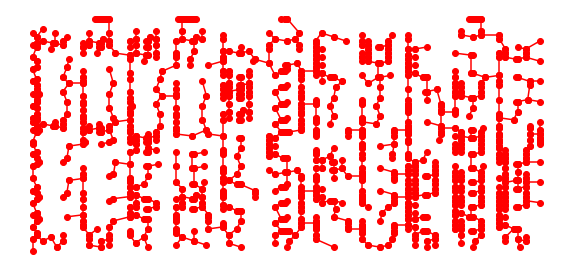

In [41]:
cities = frozenset(zip(df['X'],df['Y']))

plot_graph(mst(cities))

## Turning a Minimum Spanning Tree into a Tour

In the above section, we manage to create one minimum spanning tree. Now, let's convert this method to the generation of a tour that is no longer than twice as long as the minimum spanning tree.

In [42]:
def mst_tsp(cities):
    "Create a minimum spanning tree and walk it in pre-order, omitting duplicates."
    return preorder_traversal(mst(cities), first(cities))

def preorder_traversal(tree, root):
    "Traverse tree in pre-order, starting at root of tree."
    result = [root]
    for child in tree.get(root, ()):
        result.extend(preorder_traversal(tree, child))
    return result

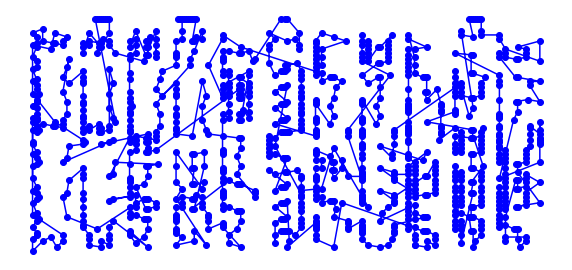

1083 city tour with length 4949.4 in 1.262 secs for mst_tsp


In [43]:
plot_tsp(mst_tsp, cities)

## Altered MST

At this section, let's try to improve the performance of the above approach in order to find better solutions. More specifically, we will implement the reversing of graph's segments.

In [44]:
def alter_tour(tour):
    "Try to alter tour for the better by reversing segments."
    original_length = tour_length(tour)
    for (start, end) in all_segments(len(tour)):
        reverse_segment_if_better(tour, start, end)
    # If we made an improvement, then try again; else stop and return tour.
    if tour_length(tour) < original_length:
        return alter_tour(tour)
    return tour

def all_segments(N):
    "Return (start, end) pairs of indexes that form segments of tour of length N."
    return [(start, start + length)
            for length in range(N, 2-1, -1)
            for start in range(N - length + 1)]
def reverse_segment_if_better(tour, i, j):
    "If reversing tour[i:j] would make the tour shorter, then do it." 
    # Given tour [...A-B...C-D...], consider reversing B...C to get [...A-C...B-D...]
    A, B, C, D = tour[i-1], tour[i], tour[j-1], tour[j % len(tour)]
    # Are old edges (AB + CD) longer than new ones (AC + BD)? If so, reverse segment.
    if distance(A, B) + distance(C, D) > distance(A, C) + distance(B, D):
        tour[i:j] = reversed(tour[i:j])

In [45]:
def altered_mst_tsp(cities): return alter_tour(mst_tsp(cities))

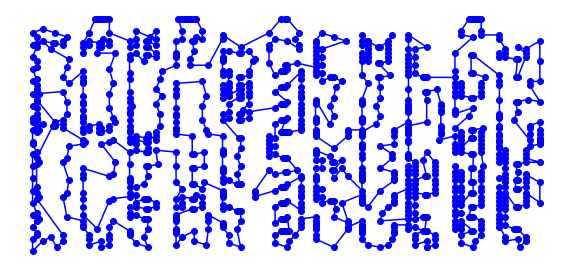

1083 city tour with length 3909.9 in 12.521 secs for altered_mst_tsp


In [46]:
plot_tsp(altered_mst_tsp, cities)

## Benchmarking for TSP Algorithms

It will be particular useful to compare the two approaches.

In [47]:
@functools.lru_cache(None)
def benchmark(function, cities):
    "Run function on all the inputs; return pair of (average_time_taken, results)."
    t0           = perf_counter()
    results      = function(cities)
    t1           = perf_counter()
    execution_time = t1 - t0
    return (execution_time, results)

In [48]:
def benchmarks(tsp_algorithms, cities):
    "Print benchmark statistics for each of the algorithms."    
    for tsp in tsp_algorithms:
        time, results = benchmark(tsp, cities)
        lengths = tour_length(results) 
        print("Algorithm: {:>15}, executed in: {:7.8f} secs for: {:3.0f} cities, with total tour length: {:5.3f}"
              .format(tsp.__name__, time, len(cities), lengths))

In [49]:
algorithms = [mst_tsp,altered_mst_tsp]

benchmarks(algorithms, frozenset(zip(df['X'],df['Y'])))

Algorithm:         mst_tsp, executed in: 1.31968178 secs for: 1083 cities, with total tour length: 4961.402
Algorithm: altered_mst_tsp, executed in: 16.02348722 secs for: 1083 cities, with total tour length: 3911.065


Algortihm | Time Complexity | Number of Cities | Length | Computation Time
--- | --- | --- |  --- | --- |
Prim's Minimum Spanning Tree | O((V + E)logV)) | 1083 | 4961.402 | 1.32 sec
Altered Prim's Minimum Spanning Tree | O((V + E)logV)) | 1083 | 3911.065 | 16.023 sec 

We conclude that Altered Prim's Minimum Spanning Tree resulted in better results, but demanded higher computation time. We should not forget, however, that both approaches generate solutions that are guaranteed to be no longer than twice as long as the minimum tour.